In [1]:
import pandas as pd
import numpy as np
import re, ast, io
from collections import Counter, defaultdict

In [2]:
csv_path = "train_test.csv"
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,name,pub_url,cu_author,date,abstract,category,Agricultural and Biological Sciences,Arts and Humanities,"Biochemistry, Genetics and Molecular Biology",...,Material Science,Mathematics,Medicine and Dentistry,Neuroscience,Nursing and Health Professions,"Pharmacology, Toxicology and Pharmaceutical Science",Physics,Psychology,Social Sciences,Veterinary Science and Veterinary Medicine
0,0,The onset of instabilities and finite amplitud...,https://pureportal.coventry.ac.uk/en/publicati...,Alex Pedcenko,Mar 2021,"In aluminum reduction cells, the electric curr...",['Physics'],0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,The efficacy of a task model approach to ADL r...,https://pureportal.coventry.ac.uk/en/publicati...,Rachel Bevins,3 Mar 2022,BACKGROUND: Apraxia and action disorganization...,"['Medicine and Dentistry', 'Nursing and Health...",0,0,0,...,0,0,1,1,1,0,0,1,0,0
2,2,The Effect of “Wave Breakers” on the Magnetohy...,https://pureportal.coventry.ac.uk/en/publicati...,Alex Pedcenko,Feb 2017,We report the results of the experiments on th...,"['Physics', 'Earth and Planetary Sciences', 'M...",0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,3,CEO Duality and Firm Performance: A Systematic...,https://pureportal.coventry.ac.uk/en/publicati...,Mei Yu,25 May 2022,This paper systematically reviews 314 empirica...,"['Social Sciences', 'Economics, Econometrics a...",0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,Knowing: Dance’s trade literature,https://pureportal.coventry.ac.uk/en/publicati...,Scott Delahunta,1 May 2022,This article explores the possibility that dan...,"['Social Sciences', 'Arts and Humanities']",0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
df.tail()

,Unnamed: 0,name,pub_url,cu_author,date,abstract,category,Agricultural and Biological Sciences,Arts and Humanities,"Biochemistry, Genetics and Molecular Biology",...,Material Science,Mathematics,Medicine and Dentistry,Neuroscience,Nursing and Health Professions,"Pharmacology, Toxicology and Pharmaceutical Science",Physics,Psychology,Social Sciences,Veterinary Science and Veterinary Medicine
15156,18415,Trust and reciprocity effect on electronic wor...,https://pureportal.coventry.ac.uk/en/publicati...,Alexeis Garcia-Perez,2019,Purpose: Social media developments in the last...,"['Psychology', 'Computer Science', 'Nursing an...",0,0,0,...,0,0,0,0,1,0,0,1,1,0
15157,18416,Unveiling the potential of ITS: Market researc...,https://pureportal.coventry.ac.uk/en/publicati...,Alexeis Garcia-Perez,1 Jan 2019,The ITS market is changing rapidly shaping the...,"['Economics, Econometrics and Finance']",0,0,0,...,0,0,0,0,0,0,0,0,0,0
15158,18417,An effective approach to collaborative knowled...,https://pureportal.coventry.ac.uk/en/publicati...,Alexeis Garcia-Perez,1 Jan 2018,This paper describes research carried out to i...,['Computer Science'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
15159,18418,Building affective commitment in a financial i...,https://pureportal.coventry.ac.uk/en/publicati...,Alexeis Garcia-Perez,12 Jan 2018,Purpose: Ambidexterity refers to the tension b...,"['Computer Science', 'Social Sciences']",0,0,0,...,0,0,0,0,0,0,0,0,1,0
15160,18419,Cybersecurity and the auto industry: The growi...,https://pureportal.coventry.ac.uk/en/publicati...,Alexeis Garcia-Perez,24 May 2018,The term 'connected cars' embraces all small p...,"['Social Sciences', 'Computer Science', 'Psych...",0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [4]:
# Map detailed academic fields -> macro labels {Business, Health, Politics}
FIELD_TO_MACRO = {
    # --- Business
    "Economics, Econometrics and Finance": "Business",
    "Business, Management and Accounting": "Business",
    "Management and Accounting": "Business",
    "Decision Sciences": "Business",

    # --- Health
    "Medicine and Dentistry": "Health",
    "Nursing and Health Professions": "Health",
    "Pharmacology, Toxicology and Pharmaceutical Science": "Health",
    "Biochemistry, Genetics and Molecular Biology": "Health",
    "Immunology and Microbiology": "Health",
    "Neuroscience": "Health",
    "Psychology": "Health",
    "Veterinary Science and Veterinary Medicine": "Health",
    "Agricultural and Biological Sciences": "Health",

    # --- Politics
    "Social Sciences": "Politics",
    "Political Science and International Relations": "Politics",
    "Law": "Politics",
    "Public Administration": "Politics",
    "Arts and Humanities": "Politics",  # heuristic: feel free to remove if you prefer stricter "Politics"
}

ONE_HOT_COLUMNS = [c for c in df.columns if c in FIELD_TO_MACRO]  # columns with 0/1

def parse_category_cell(x):
    """category column may be a Python-list-like string; return list[str]."""
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            pass
        return [x]
    return []

def map_row_to_macro(row):
    # Start from 'category' list (if present)
    cats = []
    if 'category' in row:
        cats.extend(parse_category_cell(row['category']))

    # Add any one-hot hits (if present)
    for c in ONE_HOT_COLUMNS:
        try:
            if int(row[c]) == 1:
                cats.append(c)
        except Exception:
            pass

    # Map each category to a macro label (if known)
    mapped = [FIELD_TO_MACRO.get(c.strip(), None) for c in cats if isinstance(c, str)]
    mapped = [m for m in mapped if m is not None]
    if not mapped:
        return None

    # Majority vote; tie-breaker priority (Health > Business > Politics)
    counts = Counter(mapped)
    priority = ["Health", "Business", "Politics"]
    best = sorted(counts.items(), key=lambda kv: (-kv[1], priority.index(kv[0])))[0][0]
    return best

df['macro_label'] = df.apply(map_row_to_macro, axis=1)
df['text'] = (df.get('name', '').fillna('') + ' ' + df.get('abstract', '').fillna('')).str.strip()

# Keep only rows we can map and that have text
df = df[~df['macro_label'].isna() & (df['text'].str.len() > 0)].reset_index(drop=True)

df['macro_label'].value_counts()


macro_label
Health      6132
Politics    3084
Business    1361
Name: count, dtype: int64

In [5]:
df.head()

,Unnamed: 0,name,pub_url,cu_author,date,abstract,category,Agricultural and Biological Sciences,Arts and Humanities,"Biochemistry, Genetics and Molecular Biology",...,Medicine and Dentistry,Neuroscience,Nursing and Health Professions,"Pharmacology, Toxicology and Pharmaceutical Science",Physics,Psychology,Social Sciences,Veterinary Science and Veterinary Medicine,macro_label,text
0,1,The efficacy of a task model approach to ADL r...,https://pureportal.coventry.ac.uk/en/publicati...,Rachel Bevins,3 Mar 2022,BACKGROUND: Apraxia and action disorganization...,"['Medicine and Dentistry', 'Nursing and Health...",0,0,0,...,1,1,1,0,0,1,0,0,Health,The efficacy of a task model approach to ADL r...
1,3,CEO Duality and Firm Performance: A Systematic...,https://pureportal.coventry.ac.uk/en/publicati...,Mei Yu,25 May 2022,This paper systematically reviews 314 empirica...,"['Social Sciences', 'Economics, Econometrics a...",0,0,0,...,0,0,0,0,0,0,1,0,Business,CEO Duality and Firm Performance: A Systematic...
2,4,Knowing: Dance’s trade literature,https://pureportal.coventry.ac.uk/en/publicati...,Scott Delahunta,1 May 2022,This article explores the possibility that dan...,"['Social Sciences', 'Arts and Humanities']",0,1,0,...,0,0,0,0,0,0,1,0,Politics,Knowing: Dance’s trade literature This article...
3,6,Modelling the impact of non-pharmaceutical int...,https://pureportal.coventry.ac.uk/en/publicati...,Khaled Al Khudir,15 Mar 2023,Businesses can play a key role in reducing exp...,"['Social Sciences', 'Engineering', 'Biochemist...",0,0,1,...,0,0,0,1,0,0,1,0,Health,Modelling the impact of non-pharmaceutical int...
4,7,Emotional eating among adults with healthy wei...,https://pureportal.coventry.ac.uk/en/publicati...,Sally Abbott,3 Apr 2023,Background: Emotional eating (EE) is a disorde...,"['Neuroscience', 'Psychology']",0,0,0,...,0,1,0,0,0,1,0,0,Health,Emotional eating among adults with healthy wei...


In [6]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

TOKEN_RE = re.compile(r"[A-Za-z][A-Za-z0-9_]+")

STOPWORDS = set(ENGLISH_STOP_WORDS)
def tokenize(text):
    toks = [t.lower() for t in TOKEN_RE.findall(text)]
    return [t for t in toks if len(t) > 1 and t not in STOPWORDS]

def build_inverted_index(texts):
    postings = defaultdict(list)  # term -> list of (doc_id, tfidf_weight)
    df_counts = Counter()
    per_doc_tf = []

    # raw term counts per doc + document frequencies
    for doc_id, text in enumerate(texts):
        counts = Counter(tokenize(text))
        per_doc_tf.append(counts)
        for term in counts:
            df_counts[term] += 1

    N = len(texts)
    # smooth idf
    idf = {term: np.log((1 + N) / (1 + df_)) + 1.0 for term, df_ in df_counts.items()}

    # compute tf-idf & doc norms
    doc_norms = np.zeros(N, dtype=float)
    for doc_id, counts in enumerate(per_doc_tf):
        for term, tf in counts.items():
            w = (1.0 + np.log(tf)) * idf[term]  # log-tf * idf
            postings[term].append((doc_id, w))
            doc_norms[doc_id] += w * w
    doc_norms = np.sqrt(doc_norms)
    return postings, idf, doc_norms

postings, IDF, DOC_NORMS = build_inverted_index(df['text'].tolist())
len(postings), len(IDF), len(DOC_NORMS)


(46678, 46678, 10577)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Use text column
corpus = df['text'].tolist()

# Fit TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get feature names and IDF values
terms = tfidf_vectorizer.get_feature_names_out()
idfs = tfidf_vectorizer.idf_

idf_df = pd.DataFrame({"term": terms, "idf": idfs}).sort_values("idf", ascending=False)

print("TF-IDF matrix shape:", tfidf_matrix.shape)
idf_df.head(10)


TF-IDF matrix shape: (10577, 5000)


,term,idf
4114,sclerotherapy,8.880237
4836,variceal,8.657094
1248,curcumin,8.474772
4029,rfid,8.474772
4479,sukuk,8.320622
4740,txa,8.320622
627,bfr,8.320622
4631,tillage,8.320622
4286,snap25,8.320622
3124,newtonian,8.187090


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: similarity of doc 0 with all others
sim_scores = list(enumerate(cosine_sim_matrix[0]))
sim_scores_sorted = sorted(sim_scores, key=lambda x: -x[1])[1:6]  # top-5 excluding itself

print("Top-5 most similar documents to doc 0:")
for idx, score in sim_scores_sorted:
    print(f"Doc {idx} | Similarity={score:.4f} | Title={df.loc[idx,'name']}")


Top-5 most similar documents to doc 0:
Doc 14 | Similarity=0.3167 | Title=Stepping to the Beat: Feasibility and potential efficacy of a home-based auditory-cued step training program in chronic stroke
Doc 98 | Similarity=0.2800 | Title=Metronome-Cued Stepping in Place after Hemiparetic Stroke: Comparison of a One- and Two-Tone Beat
Doc 1830 | Similarity=0.2587 | Title=Time and Performer Training
Doc 8112 | Similarity=0.2546 | Title=Impact of training and in-vehicle task performance on manual control recovery in an automated car
Doc 5637 | Similarity=0.2391 | Title=Development and evaluation of tools and an intervention to improve patient- and carer-centred outcomes in Longer-Term Stroke care and exploration of adjustment post stroke: the LoTS care research programme


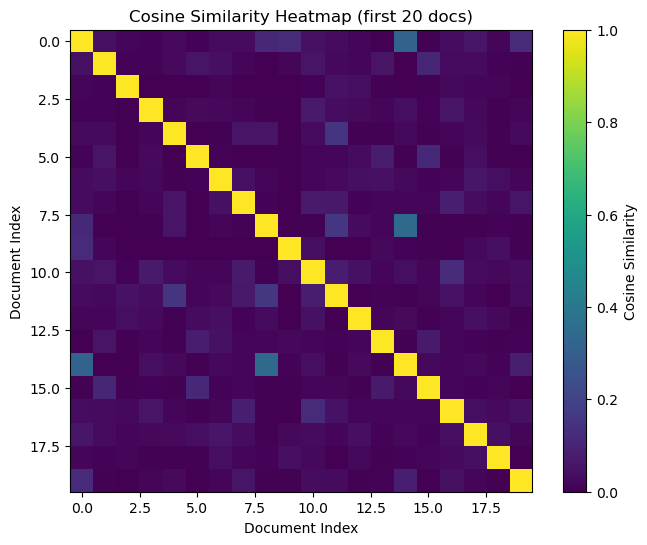

In [9]:
import matplotlib.pyplot as plt

# Take a small subset (e.g., first 20 documents) for visualization
subset_sim = cosine_sim_matrix[:20, :20]

plt.figure(figsize=(8,6))
plt.imshow(subset_sim, cmap='viridis')
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Heatmap (first 20 docs)")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()


In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

TOKEN_RE = re.compile(r"[A-Za-z][A-Za-z0-9_]+")

STOPWORDS = set(ENGLISH_STOP_WORDS)
def tokenize(text):
    toks = [t.lower() for t in TOKEN_RE.findall(text)]
    return [t for t in toks if len(t) > 1 and t not in STOPWORDS]

def build_inverted_index(texts):
    postings = defaultdict(list)  # term -> list of (doc_id, tfidf_weight)
    df_counts = Counter()
    per_doc_tf = []

    # raw term counts per doc + document frequencies
    for doc_id, text in enumerate(texts):
        counts = Counter(tokenize(text))
        per_doc_tf.append(counts)
        for term in counts:
            df_counts[term] += 1

    N = len(texts)
    # smooth idf
    idf = {term: np.log((1 + N) / (1 + df_)) + 1.0 for term, df_ in df_counts.items()}

    # compute tf-idf & doc norms
    doc_norms = np.zeros(N, dtype=float)
    for doc_id, counts in enumerate(per_doc_tf):
        for term, tf in counts.items():
            w = (1.0 + np.log(tf)) * idf[term]  # log-tf * idf
            postings[term].append((doc_id, w))
            doc_norms[doc_id] += w * w
    doc_norms = np.sqrt(doc_norms)
    return postings, idf, doc_norms

postings, IDF, DOC_NORMS = build_inverted_index(df['text'].tolist())
len(postings), len(IDF), len(DOC_NORMS)


(46678, 46678, 10577)

In [11]:
def boolean_search(query):
    terms = [t for t in tokenize(query) if t in postings]
    if not terms:
        return pd.DataFrame(columns=['name', 'pub_url', 'macro_label'])
    # intersection of all postings doc_ids
    sets = [set(doc_id for doc_id, _ in postings[t]) for t in terms]
    doc_ids = set.intersection(*sets) if sets else set()
    res = df.loc[list(doc_ids), ['name', 'pub_url', 'macro_label']].copy()
    return res.sort_index().reset_index(drop=True)

def ranked_search(query, top_k=10):
    q_counts = Counter(tokenize(query))
    qw = {}
    qnorm = 0.0
    # build query weights
    for term, tf in q_counts.items():
        if term in IDF:
            w = (1.0 + np.log(tf)) * IDF[term]
            qw[term] = w
            qnorm += w * w
    qnorm = np.sqrt(qnorm) if qnorm > 0 else 1.0

    # accumulate scores
    scores = defaultdict(float)
    for term, wq in qw.items():
        for doc_id, wd in postings.get(term, []):
            scores[doc_id] += wd * wq

    # cosine normalize
    for doc_id in list(scores.keys()):
        if DOC_NORMS[doc_id] > 0:
            scores[doc_id] /= (DOC_NORMS[doc_id] * qnorm)

    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:top_k]
    if not ranked:
        return pd.DataFrame(columns=['name', 'pub_url', 'macro_label', 'score'])
    ids, sc = zip(*ranked)
    out = df.loc[list(ids), ['name', 'pub_url', 'macro_label']].copy()
    out['score'] = sc
    return out.reset_index(drop=True)

# Quick demo
ranked_search("covid interventions closed environments", top_k=10)

,name,pub_url,macro_label,score
0,Modelling the impact of non-pharmaceutical int...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.386573
1,Modelling the impact of non-pharmaceutical int...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.386573
2,Working from home: Healthy and sustainable wor...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.190531
3,Innovation performance: The effects of closed ...,https://pureportal.coventry.ac.uk/en/publicati...,Business,0.175597
4,Interactive storytelling experience for museum...,https://pureportal.coventry.ac.uk/en/publicati...,Politics,0.146163
5,Interventions for promoting physical activity ...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.140909
6,SWING Summary Project Report,https://pureportal.coventry.ac.uk/en/publicati...,Politics,0.137263
7,The responsible sourcing of minerals for peace...,https://pureportal.coventry.ac.uk/en/publicati...,Politics,0.128184
8,Development of an online intervention for the ...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.127870
9,Development of an online intervention for the ...,https://pureportal.coventry.ac.uk/en/publicati...,Health,0.127870


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df['text'].values
y = df['macro_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline 1: Logistic Regression
logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000, ngram_range=(1,2),
        stop_words='english', sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=2000, C=2.0, class_weight='balanced', solver="liblinear", random_state=42
    ))
])

# Pipeline 2: Multinomial Naive Bayes
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000, ngram_range=(1,2),
        stop_words='english', sublinear_tf=True
    )),
    ("clf", MultinomialNB(alpha=0.1))
])

# Train
logreg_pipe.fit(X_train, y_train)
nb_pipe.fit(X_train, y_train)

# Evaluate
pred_lr = logreg_pipe.predict(X_test)
pred_nb = nb_pipe.predict(X_test)

acc_lr = accuracy_score(y_test, pred_lr)
acc_nb = accuracy_score(y_test, pred_nb)

print(f"LogReg accuracy: {acc_lr:.4f}")
print(f"Naive Bayes accuracy: {acc_nb:.4f}")



LogReg accuracy: 0.8459
Naive Bayes accuracy: 0.8015


In [13]:
print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, pred_lr))


=== Logistic Regression Report ===
              precision    recall  f1-score   support

    Business       0.74      0.76      0.75       272
      Health       0.93      0.87      0.90      1227
    Politics       0.75      0.84      0.79       617

    accuracy                           0.85      2116
   macro avg       0.81      0.82      0.81      2116
weighted avg       0.85      0.85      0.85      2116



In [14]:
print("\n=== Multinomial Naive Bayes Report ===")
print(classification_report(y_test, pred_nb))


=== Multinomial Naive Bayes Report ===
              precision    recall  f1-score   support

    Business       0.67      0.75      0.71       272
      Health       0.95      0.77      0.85      1227
    Politics       0.67      0.88      0.76       617

    accuracy                           0.80      2116
   macro avg       0.76      0.80      0.77      2116
weighted avg       0.83      0.80      0.81      2116



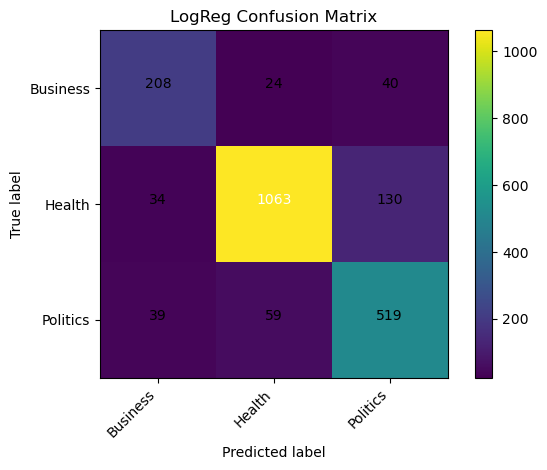

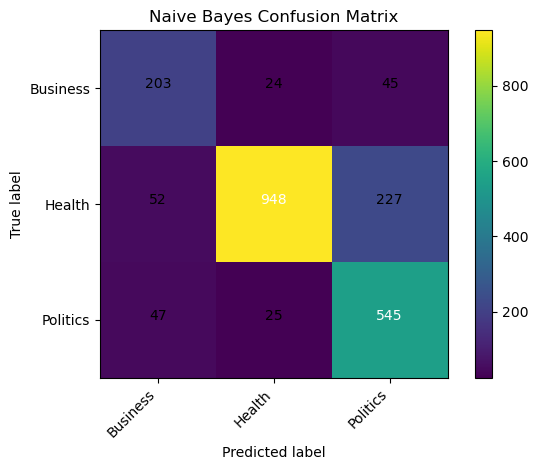

In [15]:
import matplotlib.pyplot as plt
import itertools

def plot_cm(cm, classes, title="Confusion matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

labels = sorted(pd.unique(y_test))
cm_lr = confusion_matrix(y_test, pred_lr, labels=labels)
cm_nb = confusion_matrix(y_test, pred_nb, labels=labels)

plot_cm(cm_lr, labels, "LogReg Confusion Matrix")
plot_cm(cm_nb, labels, "Naive Bayes Confusion Matrix")


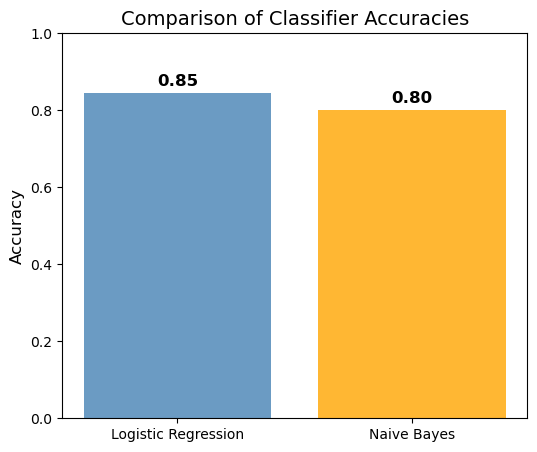

In [16]:
import matplotlib.pyplot as plt

# Accuracy scores already computed
accuracies = [acc_lr, acc_nb]
models = ["Logistic Regression", "Naive Bayes"]

plt.figure(figsize=(6,5))
bars = plt.bar(models, accuracies, color=["steelblue", "orange"], alpha=0.8)

# Annotate values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0,1)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Comparison of Classifier Accuracies", fontsize=14)
plt.show()

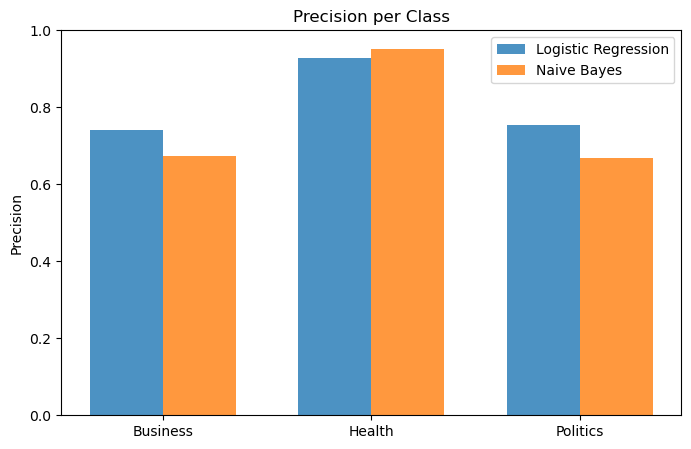

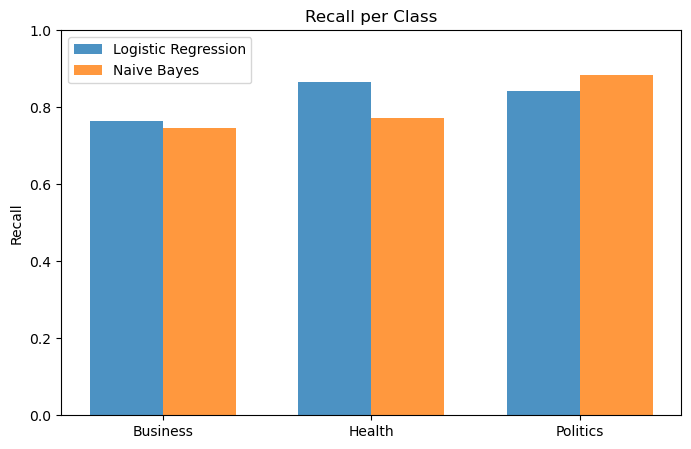

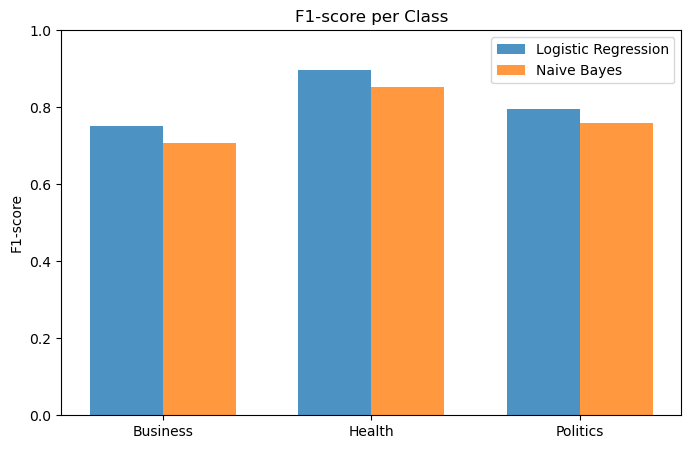

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, F1 for each class
labels = sorted(pd.unique(y_test))
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(y_test, pred_lr, labels=labels, zero_division=0)
prec_nb, rec_nb, f1_nb, _ = precision_recall_fscore_support(y_test, pred_nb, labels=labels, zero_division=0)

metrics = {
    "Precision": (prec_lr, prec_nb),
    "Recall": (rec_lr, rec_nb),
    "F1-score": (f1_lr, f1_nb)
}

# Plot grouped bar chart for each metric
x = np.arange(len(labels))  # label locations
width = 0.35

for metric_name, (lr_vals, nb_vals) in metrics.items():
    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, lr_vals, width, label="Logistic Regression", alpha=0.8)
    plt.bar(x + width/2, nb_vals, width, label="Naive Bayes", alpha=0.8)

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} per Class")
    plt.legend()
    plt.show()
